# Anatomical fiducial localization error  (AFLE) for Templates
###The notebook computes the three AFLE meterics shown below on template annotations and outputs descriptive statistics into three .csv files (mean_AFLE.csv, inter_rater_AFLE.csv, and intra_rater_AFLE.csv). It also outputs a .fscv file with consensus AFID placements. 
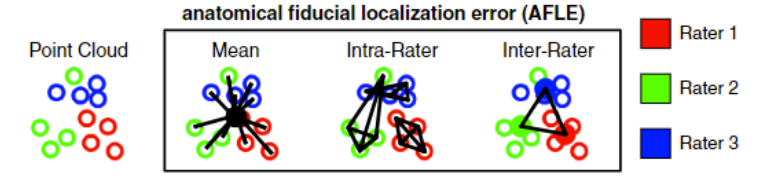

Lau, JC, Parrent, AG, Demarco, J, et al. A framework for evaluating correspondence between brain images using anatomical fiducials. Hum Brain Mapp. 2019; 40: 4163– 4179. https://doi.org/10.1002/hbm.24693

##Reading in markups file (.fcsv)

In [1]:
from glob import glob
import pandas as pd
import numpy as np 
from sklearn.metrics import pairwise_distances
import openpyxl

In [2]:
#importing the github repo
!git clone https://github.com/ataha24/afids-data 

Cloning into 'afids-data'...
remote: Enumerating objects: 1128, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1128 (delta 204), reused 318 (delta 181), pack-reused 779
Receiving objects: 100% (1128/1128), 172.37 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (821/821), done.
Checking out files: 100% (973/973), done.


In [3]:
#template placements folder (cloned to my g drive)
afids_all = pd.read_csv('afids-data/other/afids.csv') #path to csv which defines the points (i.e., fiducials)
fcsv_raters = sorted(glob('afids-data/data/templates/PD-25/RATERS/*.fcsv')) #path to rater placements 
afids_names = afids_all['description'].tolist() #adds the names of fiducials in order of application 

In [4]:
#extract all fiducials of template into one dataframe called df_afids (important to note that it assumes correct order of fiducials is placed; for this study, this has been manually quality controlled)
subjects = [filename[-15:-5] for filename in fcsv_raters] #project naming specific; need to be hard-coded }--> select rater name and session here 
subjdata = np.zeros((len(subjects),96)) # 32 fiducials in this project each with xyz hence 96 element numpy array is intialized  
for i,csv in enumerate(fcsv_raters):
  df = pd.read_table(csv,sep=',',header=2)
  df = df[['x','y','z']].melt().transpose()
  subjdata[i,:] = df.to_numpy()[1,:] 
  colnames = [ f'{i+1}' for i,ax in enumerate(df.iloc[0])]
df_afids = pd.DataFrame(subjdata,columns=colnames,index=subjects)

In [5]:
df_afids# this will have afid components (xyz) as columns and raters as rows }--> 1 = AC_x ... 33 = AC_y ... 65 = AC_z

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
5_T1_AT_01,-0.397,0.000,0.000,0.000,0.0,12.678,-13.935,10.638,-11.362,-0.362,...,-16.566,-16.702,-29.263,-27.930,3.995,4.719,5.300,6.343,-13.240,-13.240
Rater08_01,-0.076,-0.362,-0.102,-0.294,0.0,13.809,-14.055,10.806,-11.141,-0.362,...,-16.569,-16.170,-28.754,-28.486,5.070,5.070,6.149,6.166,-12.826,-13.402


## MEAN AFLE
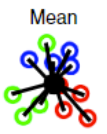

In [6]:
#compute mean placement for each afid coordinates (i.e., columns)
MEAN = df_afids.mean() #will use MEAN later to create consensus .fcsv file 

#AFLE calculation for each rater  }--> diff = (xyz_ground-truth - xyz_rater)^2
diff = (MEAN - df_afids)**2
diff

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
5_T1_AT_01,0.02576,0.032761,0.002601,0.021609,0.0,0.31979,0.0036,0.007056,0.01221,0.0,...,0.000002,0.070756,0.06477,0.077284,0.288906,0.0308,0.1802,0.007832,0.042849,0.006561
Rater08_01,0.02576,0.032761,0.002601,0.021609,0.0,0.31979,0.0036,0.007056,0.01221,0.0,...,0.000002,0.070756,0.06477,0.077284,0.288906,0.0308,0.1802,0.007832,0.042849,0.006561


In [7]:
#reorganize to combine xyz for each afid }--> euclidean distance = squareroot(x_diff + y_diff + z_diff)
df_afle = pd.DataFrame() 
for afid in range(32):
  x = afid+1
  y = x +32
  z = y +32
  ED_AFID = (np.sqrt(diff[f'{x}'] + diff[f'{y}'] + diff[f'{z}']))
  df_afle = pd.concat([df_afle, ED_AFID], axis=1)
df_afle.columns = afids_names #uses .csv file to insert col names into the data frame 

In [8]:
ED_AFID

5_T1_AT_01    0.29389
Rater08_01    0.29389
dtype: float64

In [9]:
print(f'AFLE across all raters:\n{df_afle.mean()}\n')#AFLE across all raters
print(f'MEAN AFLE across all raters and afids:\n{df_afle.mean().mean()}')#AFLE across all raters and afids 
print(f'Std Dev of AFLE across all raters and afids:\n{df_afle.mean().std()}')#AFLE across all raters and afids 

AFLE across all raters:
AC                                0.665529
PC                                0.191082
infracollicular sulcus            0.378414
PMJ                               0.509697
superior interpeduncular fossa    0.163677
R superior LMS                    0.671274
L superior LMS                    0.111572
R inferior LMS                    0.302103
L inferior LMS                    0.482769
culmen                            0.216339
intermammillary sulcus            0.251540
R MB                              0.230605
L MB                              0.273738
pineal gland                      0.570861
R LV at AC                        0.519621
L LV at AC                        0.338261
R LV at PC                        0.210406
L LV at PC                        0.297505
genu of CC                        0.255577
splenium of CC                    0.596602
R AL temporal horn                0.628864
L AL temporal horn                0.439930
R superior AM temporal horn   

In [10]:
df_afle.describe() #some descriptive stats for each AFID 

,AC,PC,infracollicular sulcus,PMJ,superior interpeduncular fossa,R superior LMS,L superior LMS,R inferior LMS,L inferior LMS,culmen,...,R superior AM temporal horn,L superior AM temporal horn,R inferior AM temporal horn,L inferior AM temporal horn,R indusium griseum origin,L indusium griseum origin,R ventral occipital horn,L ventral occipital horn,R olfactory sulcal fundus,L olfactory sulcal fundus
count,2.000000e+00,2.000000e+00,2.000000,2.000000e+00,2.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
mean,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01
std,1.110223e-16,3.925231e-17,0.000000,1.180183e-15,0.000000,7.850462e-16,1.442556e-15,2.394713e-15,5.900916e-16,1.059812e-15,...,1.138994e-15,1.413083e-15,1.241267e-16,2.159234e-15,2.512148e-15,1.570092e-16,5.024296e-15,4.710277e-16,5.900916e-16,1.217455e-15
min,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01
25%,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01
50%,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01
75%,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01
max,6.655293e-01,1.910818e-01,0.378414,5.096975e-01,0.163677,6.712740e-01,1.115717e-01,3.021030e-01,4.827686e-01,2.163389e-01,...,3.282602e-01,4.720487e-01,2.857175e-01,3.240467e-01,1.357738e+00,6.087304e-01,5.276080e-01,6.246219e-01,2.639285e-01,2.938899e-01


In [11]:
#could write to a csv file 
with pd.ExcelWriter('mean_AFLE.xlsx') as writer:
    df_afle.mean().to_excel(writer, sheet_name='AFID_MEAN_AFLE')
    df_afle.describe().to_excel(writer, sheet_name='AFID_MEAN_AFLE_STATS')

## Inter-rater AFLE 
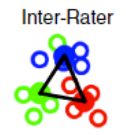

In [12]:
#assumes proper naming convention such that script sorts the file names by rater and session # 
k = 1 #how many times did each rater place the afids protocol 
n = 2 #how many raters are included in this inter-rater analysis 
count = 0 
df_rater_mean = pd.DataFrame() 
list_raters = []
for i in range(len(df_afids)//k): 
  df_rater_mean= pd.concat([df_rater_mean,(df_afids[count:count+k].mean())],axis=1)
  list_raters.append(df_afids.index.values[count])
  count += k 
df_rater_mean.columns = list_raters
df_rater_mean = df_rater_mean.transpose()
df_rater_mean #took mean acorss rater session for each afid

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
5_T1_AT_01,-0.397,0.000,0.000,0.000,0.0,12.678,-13.935,10.638,-11.362,-0.362,...,-16.566,-16.702,-29.263,-27.930,3.995,4.719,5.300,6.343,-13.240,-13.240
Rater08_01,-0.076,-0.362,-0.102,-0.294,0.0,13.809,-14.055,10.806,-11.141,-0.362,...,-16.569,-16.170,-28.754,-28.486,5.070,5.070,6.149,6.166,-12.826,-13.402


In [13]:
#iteratively assemble afids and raters into a numpay array of shape (rater,AFID_#_xyz) and use sklearn pairwise distance function
inter_afle_gen = n*((n-1)/2)
inter_afle = []
for afid1 in range(32):
  x1 = afid1+1
  y1 = x1 +32
  z1 = y1 +32
  xyz_df = pd.concat([pd.concat([df_rater_mean[f'{x1}'],df_rater_mean[f'{y1}']], axis =1),df_rater_mean[f'{z1}']], axis =1)
  xyz = xyz_df.to_numpy()
  #should not use all distances in mean caluclation; sum eliminates the zeros in matrix and x2 in denominator accounts for duplicate distances (i.e., A-->B & B-->A)
  inter_afle.append((pairwise_distances(xyz_df.to_numpy()).sum())/(inter_afle_gen*2))
  print(pd.DataFrame((pairwise_distances(xyz ,xyz)), index = list_raters, columns =list_raters)) #only mean of a each AFID is included in output .csv and not the distance matrix

            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    1.331059
Rater08_01    1.331059    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.382164
Rater08_01    0.382164    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.756828
Rater08_01    0.756828    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    1.019395
Rater08_01    1.019395    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.327355
Rater08_01    0.327355    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    1.342548
Rater08_01    1.342548    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.223143
Rater08_01    0.223143    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.604206
Rater08_01    0.604206    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.000000    0.965537
Rater08_01    0.965537    0.000000
            5_T1_AT_01  Rater08_01
5_T1_AT_01    0.0000

In [14]:
df_inter_afle = pd.DataFrame(inter_afle , index = afids_names, columns = ['inter-Rater AFLE'])
df_inter_afle

,inter-Rater AFLE
AC,1.331059
PC,0.382164
infracollicular sulcus,0.756828
PMJ,1.019395
superior interpeduncular fossa,0.327355
R superior LMS,1.342548
L superior LMS,0.223143
R inferior LMS,0.604206
L inferior LMS,0.965537
culmen,0.432678


In [15]:
df_inter_afle.describe()

,inter-Rater AFLE
count,32.000000
mean,0.837035
std,0.473683
min,0.223143
25%,0.523681
50%,0.666521
75%,1.076843
max,2.715476


In [16]:
#could write to a csv file 
with pd.ExcelWriter('inter_rater_AFLE.xlsx') as writer:
    df_inter_afle.to_excel(writer, sheet_name='AFID_INTER_AFLE')
    df_inter_afle.describe().to_excel(writer, sheet_name='AFID_rater_AFLE_STATS')

## Intra-rater AFLE (not applicalible to all of templates)
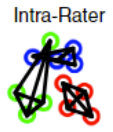

In [ ]:
#assumes proper naming convention such that script sorts the file names by rater and session # 
intra_afle_gen = k*((k-1)/2)
intra_afle = {}
count = 0 
for i in range(len(df_afids)//k): 
  for afid2 in range(32):
    x2 = afid2+1
    y2 = x2 +32
    z2 = y2 +32    
    df_afid_xyz = pd.concat([pd.concat([(df_afids[count:count+k][f'{x2}']), (df_afids[count:count+k][f'{y2}'])],axis =1), df_afids[count:count+k][f'{z2}']], axis =1)
    afid_xyz = df_afid_xyz.to_numpy()
    if df_rater_mean.index[i] not in intra_afle:
      #should not use all distances in mean caluclation; sum eliminates the zeros in matrix and x2 in denominator accounts for duplicate distances (i.e., A-->B & B-->A)
      intra_afle[f'{df_rater_mean.index[i]}'] = [(pairwise_distances(afid_xyz).sum()/(intra_afle_gen*2))]
    else: 
      intra_afle[f'{df_rater_mean.index[i]}'].append(pairwise_distances(afid_xyz).sum()/(intra_afle_gen*2))
  count += k 

intra_afle_raw = pd.DataFrame(intra_afle, index = afids_names) # clear up and put in dataframe 

In [ ]:
intra_afle_raw

In [ ]:
intra_afle_raw.describe() #within rater across all afids 

In [ ]:
print(f'Intra-Rater AFLE: {round(intra_afle_raw.describe().iloc[1].mean(),4)} +/- {round(intra_afle_raw.describe().iloc[1].std(),4)}')

In [ ]:
#could write to a csv file 
with pd.ExcelWriter('intra_rater_AFLE.xlsx') as writer:
    intra_afle_raw.to_excel(writer, sheet_name='AFID_INTRA_AFLE_RAW')
    intra_afle_raw.describe().to_excel(writer, sheet_name='WITHIN_RATER_ACROSS_AFIDS_STATS')
    intra_afle_raw.transpose().describe().to_excel(writer, sheet_name='WITHIN_AFID_ACROSS_RATERS_STATS')

##create FCSV

In [19]:
df_csv = pd.read_table('afids-data/data/templates/Colin27/Colin27_MEAN.fcsv', sep = ',',header=2) #borrow a .fcsv template from curated placements

In [20]:
df_csv['x'] = MEAN[0:32].to_numpy()
df_csv['y'] = MEAN[32:64].to_numpy()
df_csv['z'] = MEAN[64:].to_numpy()

In [21]:
dict_fcsv = ['# Markups fiducial file version = 4.10','# CoordinateSystem = 0']
fcsv_header = pd.DataFrame(dict_fcsv)
fcsv_header.to_csv('PD25_MEAN.fcsv', mode='w', index=False, header=False)
df_csv.to_csv('PD25_MEAN.fcsv', mode='a', index=False, header=True)